In [1]:
import warnings

warnings.filterwarnings('ignore')
print('-' * 25)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)


-------------------------


In [2]:
data_raw = pd.read_csv("../Data/train.csv")
data_raw["Type"] = "train"
data_val = pd.read_csv("../Data/test.csv")
data_val["Type"] = "test"

data1 = data_raw.copy(deep=True)
data_cleaner = [data1, data_val]

Sales = pd.concat(data_cleaner,ignore_index = True)

print("-" * 10)
print("Sales info\n")
print (Sales.info())
print("-" * 10)

----------
Sales info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
Item_Fat_Content             14204 non-null object
Item_Identifier              14204 non-null object
Item_MRP                     14204 non-null float64
Item_Outlet_Sales            8523 non-null float64
Item_Type                    14204 non-null object
Item_Visibility              14204 non-null float64
Item_Weight                  11765 non-null float64
Outlet_Establishment_Year    14204 non-null int64
Outlet_Identifier            14204 non-null object
Outlet_Location_Type         14204 non-null object
Outlet_Size                  10188 non-null object
Outlet_Type                  14204 non-null object
Type                         14204 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 1.4+ MB
None
----------


In [3]:
Sales.describe(include="all")

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,Type
count,14204,14204,14204.000000,8523.000000,14204,14204.000000,11765.000000,14204.000000,14204,14204,10188,14204,14204
unique,5,1559,NaN,NaN,16,NaN,NaN,NaN,10,3,3,4,2
top,Low Fat,NCQ05,NaN,NaN,Fruits and Vegetables,NaN,NaN,NaN,OUT027,Tier 3,Medium,Supermarket Type1,train
freq,8485,10,NaN,NaN,2013,NaN,NaN,NaN,1559,5583,4655,9294,8523
mean,NaN,NaN,141.004977,2181.288914,NaN,0.065953,12.792854,1997.830681,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,62.086938,1706.499616,NaN,0.051459,4.652502,8.371664,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,31.290000,33.290000,NaN,0.000000,4.555000,1985.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,94.012000,834.247400,NaN,0.027036,8.710000,1987.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,142.247000,1794.331000,NaN,0.054021,12.600000,1999.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,185.855600,3101.296400,NaN,0.094037,16.750000,2004.000000,NaN,NaN,NaN,NaN,NaN


<B>Item Weight cannot be 0. Bases on other items, the most occurent value is assigned<B>

In [4]:
UniqueItems = set(Sales.Item_Identifier)
    
for item in UniqueItems:
    Sales.loc[(Sales["Item_Identifier"] == str(item)) & (Sales["Item_Weight"].isnull()), "Item_Weight"] = \
            Sales.loc[Sales["Item_Identifier"] == str(item), "Item_Weight"].mode()[0]
       

In [5]:
Sales["Item_Weight"].isnull().sum()

0

<B>Item Visibility cannot be 0. Based on other item identifiers, the mean is assigned<B>

In [6]:
Sales["Item_Visibility"].describe()

count    14204.000000
mean         0.065953
std          0.051459
min          0.000000
25%          0.027036
50%          0.054021
75%          0.094037
max          0.328391
Name: Item_Visibility, dtype: float64

In [7]:
for item in UniqueItems:
    Sales.loc[(Sales["Item_Identifier"] == str(item)) & (Sales["Item_Visibility"] == 0), "Item_Visibility"] = \
        Sales.loc[
            (Sales["Item_Identifier"] == str(item)) & (Sales["Item_Visibility"] != 0), "Item_Visibility"].mean()

In [8]:
Sales["Item_Visibility"].describe()

count    14204.000000
mean         0.070458
std          0.050086
min          0.003575
25%          0.031381
50%          0.058064
75%          0.098042
max          0.328391
Name: Item_Visibility, dtype: float64

<B>Check for Item Fat Content<B>

In [9]:
Sales["Item_Fat_Content"].value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

In [10]:
Sales["Item_Fat_Content"].replace(['LF', 'Low Fat', 'low fat'], 'L', inplace=True)
Sales["Item_Fat_Content"].replace(['Regular', 'reg'], 'R', inplace=True)

In [11]:
Sales["Item_Fat_Content"].value_counts()

L    9185
R    5019
Name: Item_Fat_Content, dtype: int64

<B>Create feature age of the outlet</B>

In [12]:
import datetime

year = datetime.datetime.now().year
Sales["Age"] = year -  Sales["Outlet_Establishment_Year"]

In [13]:
Sales["Age"].describe()

count    14204.000000
mean        20.169319
std          8.371664
min          9.000000
25%         14.000000
50%         19.000000
75%         31.000000
max         33.000000
Name: Age, dtype: float64

<B>Create feature Quantity Sold based on Item_Outlet_Sales and Item_MRP</B>

In [14]:
Sales["Qty_Sold"] = Sales["Item_Outlet_Sales"]/Sales["Item_MRP"]

In [15]:
Sales.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,Type,Age,Qty_Sold
0,L,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,19,14.951963
1,R,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train,9,9.186454
2,L,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,19,14.809346
3,R,FDX07,182.0950,732.3800,Fruits and Vegetables,0.022930,19.20,1998,OUT010,Tier 3,NaN,Grocery Store,train,20,4.021967
4,L,NCD19,53.8614,994.7052,Household,0.014670,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train,31,18.467868


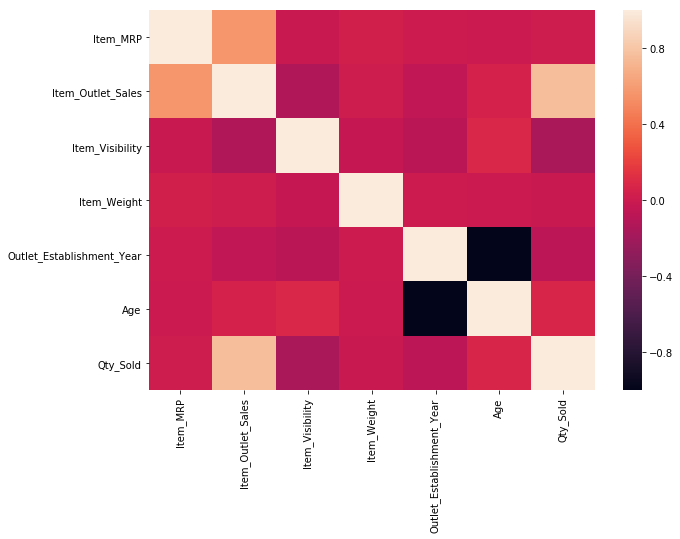

In [16]:
plt.figure(figsize=(10,7))
sns.heatmap(Sales.corr())

In [17]:
Sales.describe(include=["object"]).columns

Index(['Item_Fat_Content', 'Item_Identifier', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type', 'Type'],
      dtype='object')

In [18]:
Sales.Outlet_Size.value_counts()

Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

In [19]:
Sales.loc[Sales["Outlet_Size"].isnull(),"Outlet_Identifier"].value_counts()

OUT045    1548
OUT017    1543
OUT010     925
Name: Outlet_Identifier, dtype: int64

Looking for patterns for missing outlet size

In [20]:
Sales.loc[(Sales["Outlet_Size"].isnull()) & (Sales["Outlet_Identifier"] == "OUT045") ,].describe(include = [object])

,Item_Fat_Content,Item_Identifier,Item_Type,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,Type
count,1548,1548,1548,1548,1548,0.0,1548,1548
unique,2,1548,16,1,1,0.0,1,2
top,L,FDK43,Snack Foods,OUT045,Tier 2,NaN,Supermarket Type1,train
freq,1001,1,218,1548,1548,NaN,1548,929


In [21]:
Sales.loc[(Sales["Outlet_Size"].isnull()) & (Sales["Outlet_Identifier"] == "OUT017") ,].describe(include = [object])

,Item_Fat_Content,Item_Identifier,Item_Type,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,Type
count,1543,1543,1543,1543,1543,0.0,1543,1543
unique,2,1543,16,1,1,0.0,1,2
top,L,NCQ05,Snack Foods,OUT017,Tier 2,NaN,Supermarket Type1,train
freq,999,1,219,1543,1543,NaN,1543,926


In [22]:
Sales.loc[(Sales["Outlet_Size"].isnull()) & (Sales["Outlet_Identifier"] == "OUT010") ,].describe(include = [object])

,Item_Fat_Content,Item_Identifier,Item_Type,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,Type
count,925,925,925,925,925,0.0,925,925
unique,2,925,16,1,1,0.0,1,2
top,L,FDO36,Fruits and Vegetables,OUT010,Tier 3,NaN,Grocery Store,train
freq,595,1,137,925,925,NaN,925,555


<B>For OUT045 and OUT017, the Outlet Location Type = Tier 2 and Outlet Type =Supermarket Type 1, they can be imputed in the same manner</B>

In [23]:
Sales.loc[(Sales["Outlet_Location_Type"]=="Tier 2") & (Sales["Outlet_Type"]=="Supermarket Type1"),"Outlet_Size"].value_counts()

Small    1550
Name: Outlet_Size, dtype: int64

In [24]:
Sales.loc[(Sales["Outlet_Size"].isnull()) & (Sales["Outlet_Identifier"].isin(["OUT045","OUT017"])),"Outlet_Size"] = "Small"
Sales.loc[ (Sales["Outlet_Identifier"].isin(["OUT045","OUT017"])) ,"Outlet_Size"].value_counts()

Small    3091
Name: Outlet_Size, dtype: int64

<B>For OUT010, the outlet location type = Tier 3 and Outlet Type = Grocery Store</B>

In [25]:
Sales.loc[(Sales["Outlet_Location_Type"]== "Tier 3") & (Sales["Outlet_Type"]=="Grocery Store") ,"Outlet_Size"].value_counts()

Series([], Name: Outlet_Size, dtype: int64)

In [26]:
Sales.loc[(Sales["Outlet_Type"]=="Grocery Store") ,"Outlet_Size"].value_counts()

Small    880
Name: Outlet_Size, dtype: int64

In [27]:
Sales.loc[(Sales["Outlet_Location_Type"]== "Tier 3") ,"Outlet_Size"].value_counts()

Medium    3105
High      1553
Name: Outlet_Size, dtype: int64

In [28]:
Sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 15 columns):
Item_Fat_Content             14204 non-null object
Item_Identifier              14204 non-null object
Item_MRP                     14204 non-null float64
Item_Outlet_Sales            8523 non-null float64
Item_Type                    14204 non-null object
Item_Visibility              14204 non-null float64
Item_Weight                  14204 non-null float64
Outlet_Establishment_Year    14204 non-null int64
Outlet_Identifier            14204 non-null object
Outlet_Location_Type         14204 non-null object
Outlet_Size                  13279 non-null object
Outlet_Type                  14204 non-null object
Type                         14204 non-null object
Age                          14204 non-null int64
Qty_Sold                     8523 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 1.6+ MB


In [29]:
Sales.describe(include ="all")

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,Type,Age,Qty_Sold
count,14204,14204,14204.000000,8523.000000,14204,14204.000000,14204.000000,14204.000000,14204,14204,13279,14204,14204,14204.000000,8523.000000
unique,2,1559,NaN,NaN,16,NaN,NaN,NaN,10,3,3,4,2,NaN,NaN
top,L,NCQ05,NaN,NaN,Fruits and Vegetables,NaN,NaN,NaN,OUT027,Tier 3,Small,Supermarket Type1,train,NaN,NaN
freq,9185,10,NaN,NaN,2013,NaN,NaN,NaN,1559,5583,7071,9294,8523,NaN,NaN
mean,NaN,NaN,141.004977,2181.288914,NaN,0.070458,12.793380,1997.830681,NaN,NaN,NaN,NaN,NaN,20.169319,15.425685
std,NaN,NaN,62.086938,1706.499616,NaN,0.050086,4.651716,8.371664,NaN,NaN,NaN,NaN,NaN,8.371664,9.192655
min,NaN,NaN,31.290000,33.290000,NaN,0.003575,4.555000,1985.000000,NaN,NaN,NaN,NaN,NaN,9.000000,0.952322
25%,NaN,NaN,94.012000,834.247400,NaN,0.031381,8.710000,1987.000000,NaN,NaN,NaN,NaN,NaN,14.000000,8.949479
50%,NaN,NaN,142.247000,1794.331000,NaN,0.058064,12.600000,1999.000000,NaN,NaN,NaN,NaN,NaN,19.000000,14.926893
75%,NaN,NaN,185.855600,3101.296400,NaN,0.098042,16.750000,2004.000000,NaN,NaN,NaN,NaN,NaN,31.000000,21.092696


In [30]:
Sales.loc[Sales["Outlet_Size"].isnull(),].shape

(925, 15)

In [31]:
Sales['Item_Type'].value_counts()

Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

<B> Changing categorical data to numeric/dummy</B>

In [32]:
mapping_Item_Type = {'Fruits and Vegetables': "Fruit_Veg",
                    'Household':"HH_HH", 'Health and Hygiene':"HH_HH",
                    'Baking Goods': "Bake_Snacks", 'Snack Foods': "Bake_Snacks",
                    'Canned': "Frozen_Canned", 'Frozen Foods': "Frozen_Canned",
                    'Dairy': "DBBS", 'Breakfast': "DBBS", 'Breads': "DBBS", 'Starchy Foods': "DBBS",
                    'Seafood':"Seafood_Meat", 'Meat': "Seafood_Meat",
                    'Hard Drinks': "Drinks", 'Soft Drinks': "Drinks",
                    'Others':"Others"}
Sales['Item_Type'] = Sales['Item_Type'].map(mapping_Item_Type)

mapping_Item_Fat_Content = {'R': 1, "L":0}
Sales['Item_Fat_Content'] = Sales['Item_Fat_Content'].map(mapping_Item_Fat_Content)

mapping_Outlet_Size = {'Small': 1, "Medium": 2,'High': 3}
Sales['Outlet_Size'] = Sales['Outlet_Size'].map(mapping_Outlet_Size)

In [33]:
Sales.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,Type,Age,Qty_Sold
0,0,FDA15,249.8092,3735.1380,DBBS,0.016047,9.30,1999,OUT049,Tier 1,2.0,Supermarket Type1,train,19,14.951963
1,1,DRC01,48.2692,443.4228,Drinks,0.019278,5.92,2009,OUT018,Tier 3,2.0,Supermarket Type2,train,9,9.186454
2,0,FDN15,141.6180,2097.2700,Seafood_Meat,0.016760,17.50,1999,OUT049,Tier 1,2.0,Supermarket Type1,train,19,14.809346
3,1,FDX07,182.0950,732.3800,Fruit_Veg,0.022930,19.20,1998,OUT010,Tier 3,NaN,Grocery Store,train,20,4.021967
4,0,NCD19,53.8614,994.7052,HH_HH,0.014670,8.93,1987,OUT013,Tier 3,3.0,Supermarket Type1,train,31,18.467868


In [34]:
Sales['Item_Type'].value_counts()

Bake_Snacks      3075
Frozen_Canned    2510
HH_HH            2406
Fruit_Veg        2013
DBBS             2007
Drinks           1088
Seafood_Meat      825
Others            280
Name: Item_Type, dtype: int64

In [35]:
Sales = pd.get_dummies(Sales,columns=["Item_Type","Outlet_Identifier","Outlet_Location_Type","Outlet_Type"],drop_first=True)

In [36]:
Sales.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Size,Type,Age,Qty_Sold,Item_Type_DBBS,Item_Type_Drinks,Item_Type_Frozen_Canned,Item_Type_Fruit_Veg,Item_Type_HH_HH,Item_Type_Others,Item_Type_Seafood_Meat,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0,FDA15,249.8092,3735.1380,0.016047,9.30,1999,2.0,train,19,14.951963,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,1,DRC01,48.2692,443.4228,0.019278,5.92,2009,2.0,train,9,9.186454,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2,0,FDN15,141.6180,2097.2700,0.016760,17.50,1999,2.0,train,19,14.809346,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,1,FDX07,182.0950,732.3800,0.022930,19.20,1998,NaN,train,20,4.021967,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,NCD19,53.8614,994.7052,0.014670,8.93,1987,3.0,train,31,18.467868,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0


In [37]:
Sales.columns

Index(['Item_Fat_Content', 'Item_Identifier', 'Item_MRP', 'Item_Outlet_Sales',
       'Item_Visibility', 'Item_Weight', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Type', 'Age', 'Qty_Sold', 'Item_Type_DBBS',
       'Item_Type_Drinks', 'Item_Type_Frozen_Canned', 'Item_Type_Fruit_Veg',
       'Item_Type_HH_HH', 'Item_Type_Others', 'Item_Type_Seafood_Meat',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'],
      dtype='object')

In [38]:
X_Cols = ['Item_Fat_Content', 'Item_MRP',
       'Item_Visibility', 'Item_Weight',
       'Qty_Sold', 'Age', 'Item_Type_DBBS',
       'Item_Type_Drinks', 'Item_Type_Frozen_Canned', 'Item_Type_Fruit_Veg',
       'Item_Type_HH_HH', 'Item_Type_Others', 'Item_Type_Seafood_Meat',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3']
y_cols = 'Outlet_Size'

In [39]:
from sklearn.model_selection import train_test_split
X = Sales.loc[(Sales[y_cols].notnull()) & (Sales['Type'] == "train"), X_Cols]
y = Sales.loc[(Sales[y_cols].notnull()) & (Sales['Type'] == "train"), y_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [40]:
print("Shape of X_train: ",X_train.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of y_test: ",y_test.shape)

Shape of X_train:  (5577, 27)
Shape of y_train:  (5577,)
Shape of X_test:  (2391, 27)
Shape of y_test:  (2391,)


In [41]:
Sales[y_cols].value_counts()

1.0    7071
2.0    4655
3.0    1553
Name: Outlet_Size, dtype: int64

<B>Trying KNN</B>

In [42]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
KNeighborsClassifier()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [43]:
def IdentifyKValueCrossValidation(X,Y,startK,endK,cv,scoring):
    k_range = list(range(startK, endK+1))
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, Y, cv=cv,scoring=scoring)
        k_scores.append(scores.mean())
    z = [i for i, j in enumerate(k_scores) if j == max(k_scores)]
    
    print("Location for Max Accuaracy is:")
    
    for i in z:
        print(k_range[i])
    
    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    
    return k_range[i]

Location for Max Accuaracy is:
1
Value of K with is: 1


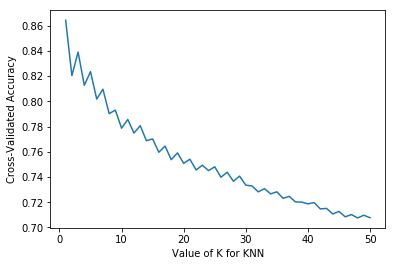

In [44]:
from sklearn.model_selection import cross_val_score

K = IdentifyKValueCrossValidation(X=X,Y=y,cv=5,startK=1,endK=50,scoring="accuracy")
print("Value of K with is: {}".format(K))

In [45]:
knn = KNeighborsClassifier(n_neighbors=K)
y_predicted = knn.fit(X_train,y_train).predict(X_test)
print("Test Accuracy: ", (y_predicted == y_test).astype(int).sum()/y_test.shape[0])

Test Accuracy:  0.8519447929736512


In [46]:
pd.Series(knn.predict(X=Sales.loc[(Sales[y_cols].isnull()) & (Sales['Type'] == "train"), X_Cols])).value_counts()

1.0    303
2.0    252
dtype: int64

<B>Multinomial Classifier</B>

In [47]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
md = OneVsOneClassifier(LinearSVC(random_state=0)).fit(X_train, y_train)
y_predicted = md.predict(X=X_test)
print("Test Accuracy: ", (y_predicted == y_test).astype(int).sum()/y_test.shape[0])

Test Accuracy:  1.0


In [48]:
pd.Series(md.predict(X=Sales.loc[(Sales[y_cols].isnull()) & (Sales['Type'] == "train"), X_Cols])).value_counts()

2.0    555
dtype: int64

<B>AdaBoost</B>

In [49]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, X_train, y_train)
scores.mean()

1.0

In [50]:
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

In [51]:
pd.Series(clf.predict(X=Sales.loc[(Sales[y_cols].isnull()) & (Sales['Type'] == "train"), X_Cols])).value_counts()

2.0    555
dtype: int64

<B>Hence, Medium Outlet Size is Chosen</B>

In [52]:
Sales.loc[(Sales["Outlet_Size"].isnull()),"Outlet_Size"] = 2
Sales["Outlet_Size"].value_counts()

1.0    7071
2.0    5580
3.0    1553
Name: Outlet_Size, dtype: int64

In [64]:
Sales["Outlet_Size"] = Sales["Outlet_Size"].astype(int).astype(object)
Sales.isnull().sum()

Item_Fat_Content                    0
Item_Identifier                     0
Item_MRP                            0
Item_Outlet_Sales                5681
Item_Visibility                     0
Item_Weight                         0
Outlet_Establishment_Year           0
Outlet_Size                         0
Type                                0
Age                                 0
Qty_Sold                         5681
Item_Type_DBBS                      0
Item_Type_Drinks                    0
Item_Type_Frozen_Canned             0
Item_Type_Fruit_Veg                 0
Item_Type_HH_HH                     0
Item_Type_Others                    0
Item_Type_Seafood_Meat              0
Outlet_Identifier_OUT013            0
Outlet_Identifier_OUT017            0
Outlet_Identifier_OUT018            0
Outlet_Identifier_OUT019            0
Outlet_Identifier_OUT027            0
Outlet_Identifier_OUT035            0
Outlet_Identifier_OUT045            0
Outlet_Identifier_OUT046            0
Outlet_Ident

In [65]:
from sklearn import metrics
from sklearn.metrics import r2_score

In [66]:
Sales.columns

Index(['Item_Fat_Content', 'Item_Identifier', 'Item_MRP', 'Item_Outlet_Sales',
       'Item_Visibility', 'Item_Weight', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Type', 'Age', 'Qty_Sold', 'Item_Type_DBBS',
       'Item_Type_Drinks', 'Item_Type_Frozen_Canned', 'Item_Type_Fruit_Veg',
       'Item_Type_HH_HH', 'Item_Type_Others', 'Item_Type_Seafood_Meat',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'],
      dtype='object')

In [71]:
XCols = ['Item_Fat_Content', 'Item_MRP',
       'Item_Visibility', 'Item_Weight',
       'Outlet_Size', 'Age', 'Item_Type_DBBS',
       'Item_Type_Drinks', 'Item_Type_Frozen_Canned', 'Item_Type_Fruit_Veg',
       'Item_Type_HH_HH', 'Item_Type_Others', 'Item_Type_Seafood_Meat',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3']
YCols = 'Qty_Sold'

In [72]:
XX = Sales.loc[Sales["Type"]=="train",XCols]
yy = Sales.loc[Sales["Type"]=="train",YCols]
print(XX.shape)
print(yy.shape)
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=0.3, random_state=5)

(8523, 27)
(8523,)


<B> Linear regression with all columns </B>

In [73]:
XX_train.head()

,Item_Fat_Content,Item_MRP,Item_Visibility,Item_Weight,Outlet_Size,Age,Item_Type_DBBS,Item_Type_Drinks,Item_Type_Frozen_Canned,Item_Type_Fruit_Veg,Item_Type_HH_HH,Item_Type_Others,Item_Type_Seafood_Meat,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
945,1,58.3588,0.021344,13.650,2,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7696,0,110.2886,0.100075,19.200,1,21,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4921,0,240.9196,0.098109,17.750,2,9,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
3538,1,39.2848,0.162461,7.855,1,11,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
651,0,46.5402,0.121880,11.800,2,20,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [74]:
from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=True,normalize=True)
reg.fit(XX_train,yy_train)
print(reg.intercept_)
reg.coef_

3.861729154447497


array([ 3.62534516e-01,  1.97125177e-03, -4.75344569e-01, -2.41986204e-02,
        4.46190132e-02,  9.67378310e-02, -3.26130084e-01,  4.12913460e-02,
       -5.16302906e-02,  2.04488397e-01,  5.14234912e-02, -2.63428399e-01,
        4.12101856e-02,  5.39592959e+00,  2.47052074e+00,  6.28876741e+00,
       -4.64406211e+00,  1.15404264e+01,  1.97612887e+00,  5.60706140e-01,
        3.05114647e+00,  3.46491004e+00,  2.21588498e+00, -3.56499323e+00,
        7.29245908e+00,  6.28876741e+00,  1.15404264e+01])

In [75]:
print(len(reg.coef_))
len(XCols)

27


27

In [76]:
coef1 = pd.DataFrame(reg.coef_,XCols,columns=["Value"])

In [77]:
yy_predicted = reg.predict(XX_test)
metrics.mean_squared_error(y_true=yy_test, y_pred=yy_predicted)

48.699882096521854

In [78]:
r2_score(yy_test, yy_predicted)

0.41814067440785563

<B> LASSO</B>

In [79]:
Lasso = linear_model.LassoCV(cv=5,normalize=True,random_state=10,alphas=[.0005])
Lasso
Lasso.fit(XX_train,yy_train)
print(Lasso.intercept_)
coef1 = pd.DataFrame(Lasso.coef_,XCols,columns=["Value"])
coef1[coef1["Value"]>0].sort_values(by="Value",ascending=False)

2.9825028778596856


,Value
Outlet_Type_Supermarket Type1,13.441345
Outlet_Identifier_OUT027,12.640825
Outlet_Type_Supermarket Type3,11.181365
Outlet_Type_Supermarket Type2,10.809769
Outlet_Identifier_OUT017,0.499518
Outlet_Identifier_OUT035,0.316412
Item_Fat_Content,0.276729
Outlet_Identifier_OUT049,0.158667
Item_Type_Fruit_Veg,0.123331
Item_MRP,0.001319


In [80]:
yy_predictedyy_predic  = Lasso.predict(XX_test)
print(metrics.mean_squared_error(y_true=yy_test, y_pred=yy_predicted))
print(r2_score(yy_test, yy_predicted))

48.699882096521854
0.41814067440785563


In [81]:
Lasso.fit(XX,yy)

LassoCV(alphas=[0.0005], copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=10, selection='cyclic', tol=0.0001,
    verbose=False)

<B>Testing the model</B>

In [82]:
Sales_Predict = Sales.loc[Sales["Type"]=="test",XCols]
Sales_Predict.head()

,Item_Fat_Content,Item_MRP,Item_Visibility,Item_Weight,Outlet_Size,Age,Item_Type_DBBS,Item_Type_Drinks,Item_Type_Frozen_Canned,Item_Type_Fruit_Veg,Item_Type_HH_HH,Item_Type_Others,Item_Type_Seafood_Meat,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8523,0,107.8622,0.007565,20.750,2,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
8524,1,87.3198,0.038428,8.300,1,11,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
8525,0,241.7538,0.099575,14.600,2,20,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8526,0,155.0340,0.015388,7.315,1,11,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
8527,1,234.2300,0.118599,13.600,2,33,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1


In [83]:
Lasso_Prediction = Lasso.predict(Sales_Predict)
print(Lasso_Prediction[:5])

[16.38839972 16.53388655  3.02660887 16.50001025 26.61073934]


In [87]:
Data_Predicted = data_val.loc[:,["Item_Identifier","Outlet_Identifier","Item_MRP"]]
Data_Predicted["Item_Outlet_Sales"] = pd.Series(Lasso_Prediction) * Data_Predicted["Item_MRP"]

In [88]:
Data_Predicted.head()

,Item_Identifier,Outlet_Identifier,Item_MRP,Item_Outlet_Sales
0,FDW58,OUT049,107.8622,1767.688848
1,FDW14,OUT017,87.3198,1443.735667
2,NCN55,OUT010,241.7538,731.694195
3,FDQ58,OUT017,155.0340,2558.062588
4,FDY38,OUT027,234.2300,6233.033476


In [89]:
Data_Predicted.drop(["Item_MRP"],axis=1,inplace=True)

In [90]:
Data_Predicted.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1767.688848
1,FDW14,OUT017,1443.735667
2,NCN55,OUT010,731.694195
3,FDQ58,OUT017,2558.062588
4,FDY38,OUT027,6233.033476


In [91]:
Data_Predicted.to_csv("../Data/SalesPrediction_submission.csv", index=False)